# Ex1. Encoding-LIF-STDP functions

## 1.  Encoding:
Implement a function that converts a continuous signal into spike trains using a simple rate coding method Input: a continuous input signal (e.g., a sine wave or random signal) Output: a poison/temporal spike train

In [1]:
import snntorch as snn
import torch
from torchvision import datasets, transforms
from snntorch import utils
from torch.utils.data import DataLoader
from snntorch import spikegen
import numpy as np

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [2]:
#training paramter
batch_size = 128
data_path = '../tmp/data/mnist'
num_classes = 10 #MNIST has 10 output classes

#torch variable
dtype = torch.float

In [3]:
#define transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform = transform)

In [4]:
# Encoding does not require large datasets.
# Use `data_subset` to reduce the dataset size by a given factor.
subnet = 10
mnist_train = utils.data_subset(mnist_train, subnet)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


In [5]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

## Rate Coding - MNIST

In [6]:
num_steps = 100
data_it, targets_it = next(iter(train_loader))

#spiking data
spike_data = spikegen.rate(data_it, num_steps = num_steps)

In [7]:
spike_data.size()

torch.Size([100, 128, 1, 28, 28])

In [8]:
# the first sample
spike_data_sample = spike_data[:, 0,0] 
print(spike_data_sample.size())
torch.Size([100, 28, 28])

torch.Size([100, 28, 28])


torch.Size([100, 28, 28])

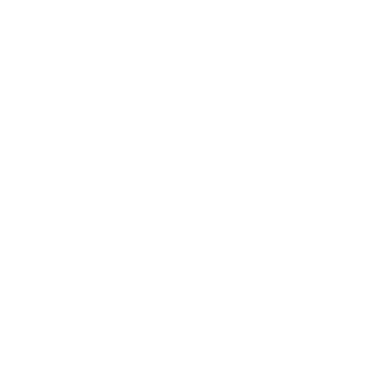

In [9]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
HTML(anim.to_html5_video())

In [10]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 2


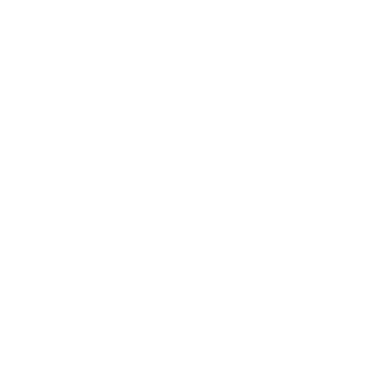

In [11]:
# with gain 
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]

fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

Text(0.5, 1.0, 'Gain = 0.25')

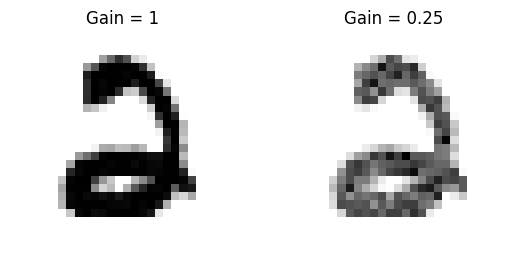

In [12]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

## 2. Leaky Integrate-and-Fire (LIF) Neuron Model: 
Implement a class for an LIF neuron. Simulate the neuron's response to a step current input. Plot the membrane potential over time and show when spikes occur.

In [13]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [14]:
lif1 = snn.Leaky(beta=0.8)

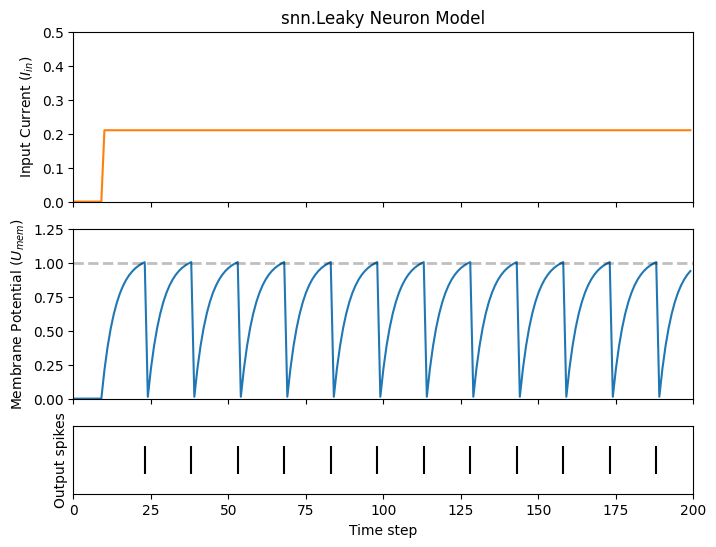

In [15]:
num_steps = 200
w = 0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190) * w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

for step in range(num_steps):
    spk, mem = lif1(cur_in[step], mem)
    mem_rec.append(mem)
    spk_rec.append(spk)

mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

## 3. Spike-Timing-Dependent Plasticity (STDP)
Implement a function that updates synaptic weights using STDP. If pre-synaptic spike happens before the post-synaptic spike → Strengthen the synapse (LTP). If pre-synaptic spike happens after the post-synaptic spike → Weaken the synapse (LTD). Visualize the weight changes over multiple spike pairings

In [16]:
num_steps = 200
pre_spike_times = [10, 30, 50, 70, 91, 120]
post_spike_times = [15, 25, 53, 65, 90, 122]

pre_spikes = torch.zeros(num_steps, 1)
post_spikes = torch.zeros(num_steps, 1)

pre_spikes[pre_spike_times] = 1
post_spikes[post_spike_times] = 1


In [17]:
def stdp_update(delta_t, w, A_plus=0.01, A_minus=0.012, tau=20):
    if delta_t > 0:
        dw = A_plus * np.exp(-delta_t / tau)
    else:
        dw = -A_minus * np.exp(delta_t / tau)
    return w + dw

In [18]:
w = 0.5
dt = 1
weight_record = [w]
last_pre_time = -np.inf
last_post_time = -np.inf

for t in range(num_steps):
    if pre_spikes[t] == 1:
        last_pre_time = t
    if post_spikes[t] == 1:
        last_post_time = t

    if last_pre_time > -np.inf and last_post_time > -np.inf:
        delta_t = (last_post_time - last_pre_time) * dt
        w = stdp_update(delta_t, w)
        w = np.clip(w, 0, 1)
        
    weight_record.append(w)

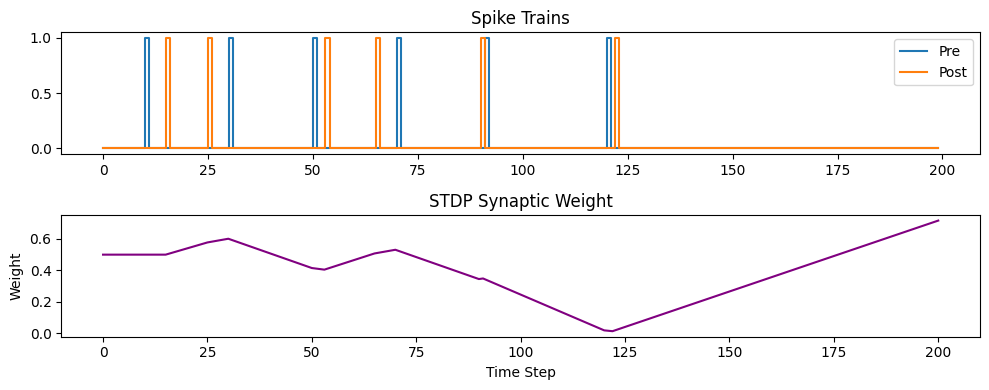

In [19]:
plt.figure(figsize=(10, 4))
plt.subplot(2,1,1)
plt.title("Spike Trains")
plt.plot(pre_spikes, label='Pre', drawstyle='steps-post')
plt.plot(post_spikes, label='Post', drawstyle='steps-post')
plt.legend()

plt.subplot(2,1,2)
plt.title("STDP Synaptic Weight")
plt.plot(weight_record, color='purple')
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()